In [1]:
%%bash
# Create da
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C ./data/models/
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C ./data/models/
rm adv_inception_v3_2017_08_18.tar.gz

inception_v3.ckpt
adv_inception_v3.ckpt.data-00000-of-00001
adv_inception_v3.ckpt.index
adv_inception_v3.ckpt.meta


--2018-04-24 21:54:13--  http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.217.48, 2607:f8b0:400a:808::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.217.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100885009 (96M) [application/x-tar]
Saving to: ‘inception_v3_2016_08_28.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 3.27M 29s
    50K .......... .......... .......... .......... ..........  0% 7.33M 21s
   100K .......... .......... .......... .......... ..........  0% 13.6M 17s
   150K .......... .......... .......... .......... ..........  0% 15.9M 14s
   200K .......... .......... .......... .......... ..........  0% 20.5M 12s
   250K .......... .......... .......... .......... ..........  0% 23.1M 11s
   300K .......... .......... .......... .......... ..........  0% 33.1M 10s
   350K .......... .......... ..

In [1]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/inception_tensorflow.ipynb
import pandas as pd
import numpy as np
from sklearn import metrics

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

from skater.util.dataops import json_validator
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal 
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_visualizer import visualize

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
slim = tf.contrib.slim

file_directory = '../../../Skater/build/lib/skater/util/model_specific/imagenet_label.json'
json_data = open(file_directory).read()
json_validator(json_data)

True

In [3]:
resized_img = load_image('./data/images/pandas.jpg', 299, 299)
input_resized_img = resized_img.reshape((1, 299, 299, 3))

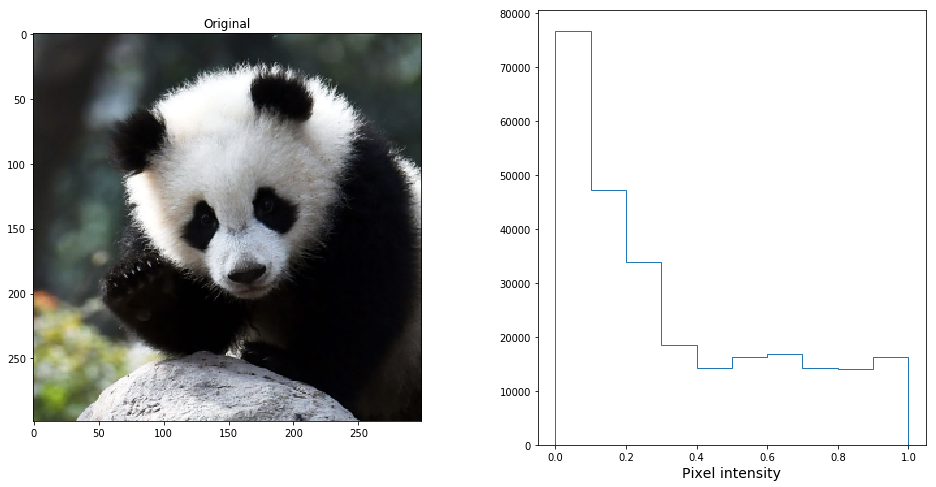

In [4]:
%matplotlib inline
show_image(input_resized_img[0])

In [5]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = './data/models/inception_v3.ckpt'

In [6]:
# Load the labels related to imagenet dataset
import json
tf.reset_default_graph()
sess = tf.Session()
labels = json.loads(json_data)

In [7]:
tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_resized_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


In [8]:
from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

,Class Labels,Scores
0,"giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca",0.934644
1,soccer ball,0.001220
2,space shuttle,0.000602


In [11]:
from skater.util.logger import build_logger
from skater.util.logger import _INFO

with DeepInterpreter(session=sess) as de:
    de.logger = build_logger(_INFO, __name__)
    relevancy_scores = {
        'e-LRP': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case="image"),
       'integrated gradient': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case="image"),
    }
    print ("success...")

2018-04-25 00:01:26,453 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.relevance_scorer.IntegratedGradients'>})])
2018-04-25 00:01:26,454 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>
2018-04-25 00:01:26,455 - LRP - INFO - Epsilon value: 0.0001
2018-04-25 00:01:26,456 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.relevance_scorer.LRP object at 0x7f40ebbf9a20>
2018-04-25 00:01:26,457 - BaseGradient - INFO - Executing operations ...
2018-04-25 00:01:29,879 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.relevan

success...


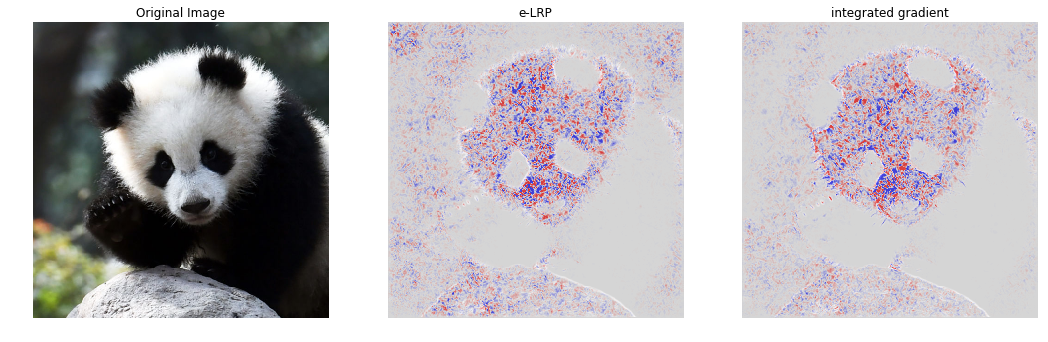

In [13]:
# Plot relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original Image')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

### Transforming the image to generate adversarial example

#### 1. Measuring sensitivity by flipping pixels

2018-04-25 00:09:49,612 - skater.util.image_ops - INFO - Number of pixels matching the condition : 18573
2018-04-25 00:09:49,613 - skater.util.image_ops - INFO - Number of pixels specified to be replaced : 3000


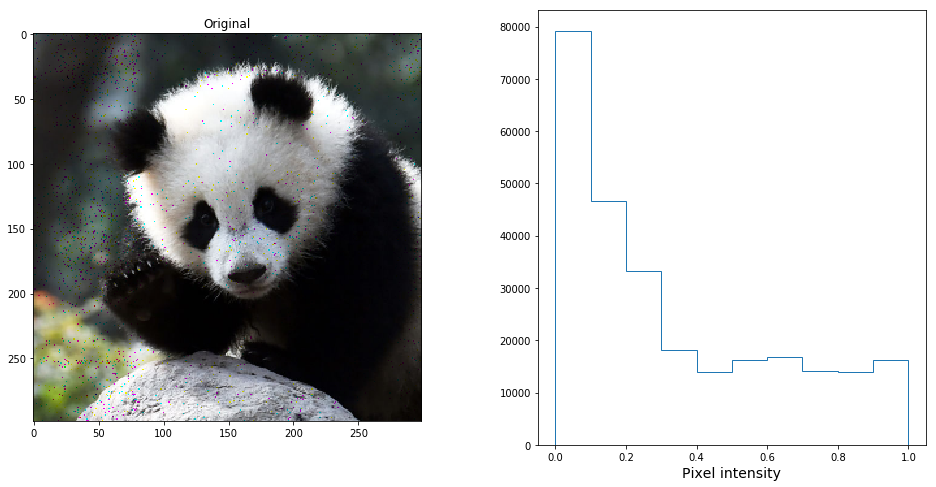

In [14]:
X = input_resized_img[0]
n_in_img = flip_pixels(X, 3000, filtered_pixel=in_between(X, 0.3, 0.4))
show_image(n_in_img)

In [15]:
input_img = normalize(n_in_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
top_k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=top_k)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


,Class Labels,Scores
0,"giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca",0.943118
1,soccer ball,0.001227
2,"lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens",0.000820


In [22]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
       'ig': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case='image')
    }
    print ("success...")

2018-04-25 00:20:54,157 - LRP - INFO - Epsilon value: 0.0001
2018-04-25 00:20:54,158 - BaseGradient - INFO - Executing operations ...
2018-04-25 00:20:57,655 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


success...


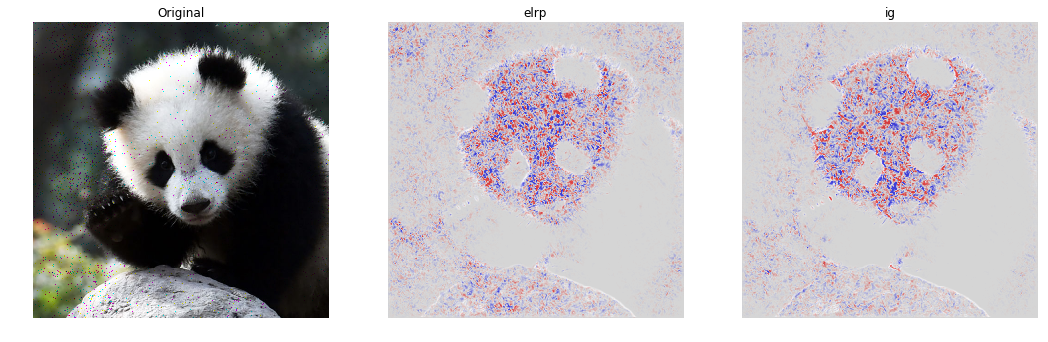

In [23]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

#### 2. By adding noise

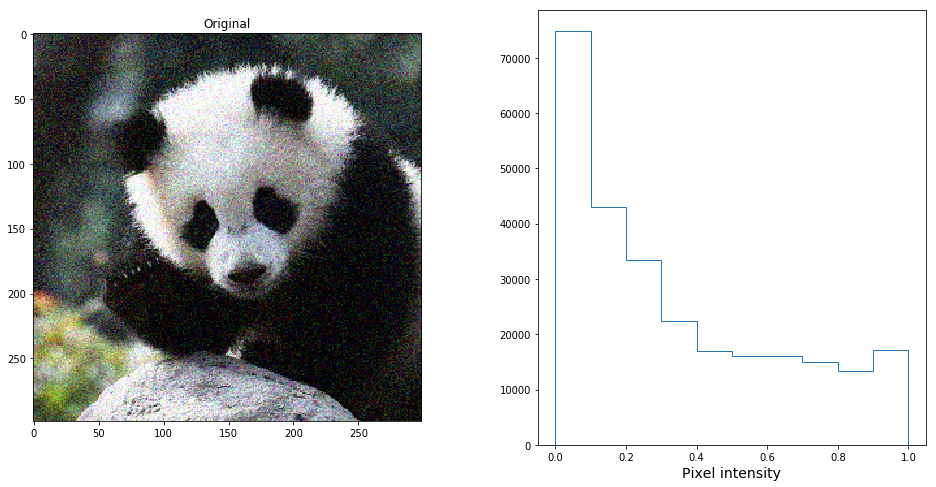

In [24]:
# a. gaussian noise
with_noise_img = add_noise(input_resized_img[0], noise_typ='gaussian', random_state=0)
show_image(with_noise_img)

#### 3. By image transformation

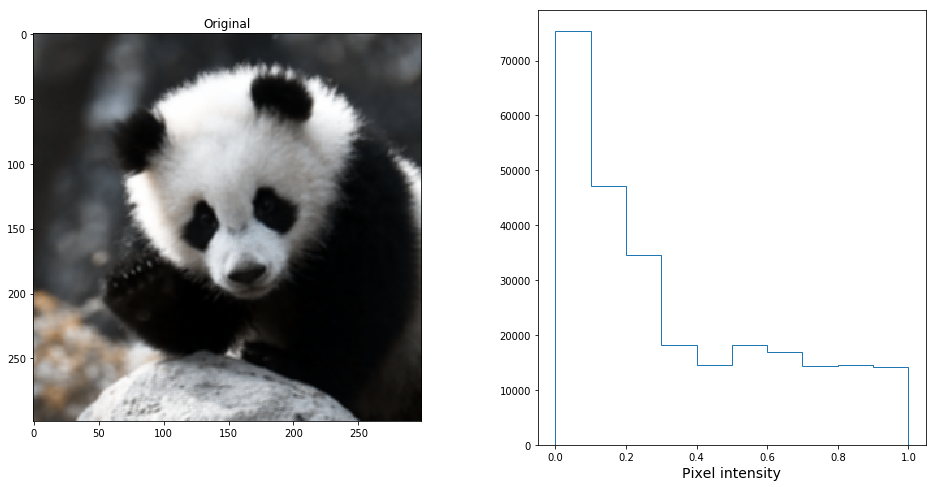

In [25]:
# 3.1. Trying blurring an image
blurred_img = image_transformation(input_resized_img[0], method_type='blur')
show_image(blurred_img)

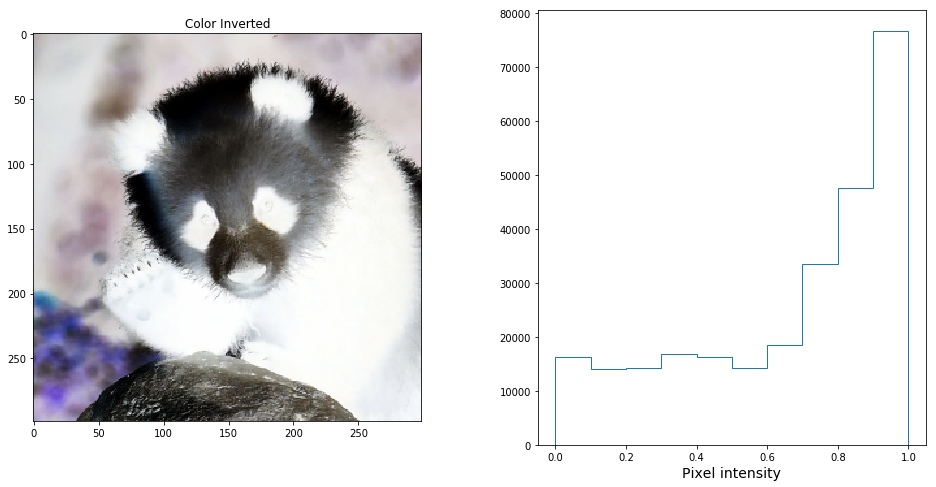

In [30]:
# 3.2 Applying color inversion
inverted_color_img = image_transformation(input_resized_img[0], method_type='invert')
show_image(inverted_color_img, title='Color Inverted')

In [27]:
input_img = normalize(inverted_color_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


,Class Labels,Scores
0,"indri, indris, Indri indri, Indri brevicaudatus",0.266485
1,"guenon, guenon monkey",0.037744
2,"colobus, colobus monkey",0.035104


In [28]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
        'integrated gradient': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
    }
    print ("success...")

2018-04-25 00:21:51,707 - LRP - INFO - Epsilon value: 0.0001
2018-04-25 00:21:51,708 - BaseGradient - INFO - Executing operations ...
2018-04-25 00:21:54,852 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


success...


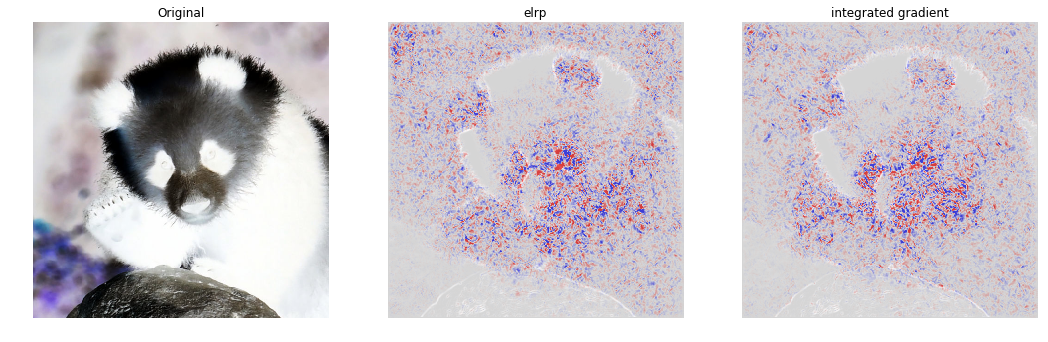

In [29]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)